#### PREDICT HEALTH CARE COST FOR PATIENTS IN HOSPITAL
- Use the National Readmission Database

In [ ]:
import os
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.preprocessing import Imputer , OneHotEncoder, LabelEncoder
from sklearn.metrics import recall_score, precision_score, average_precision_score, roc_auc_score
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from scipy.stats import sem

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


os.chdir('C:/Users/binh/Dropbox (CareSkore)/Customer_data/MEPS_expenditure prediction')

In [2]:
# import NRD - newer file with 50% sample
nrd_big = pd.read_stata('C:/Users/binh/Dropbox (CareSkore)/Research Data/NRD_final/NRD_2013_v4.dta')

In [3]:
nrd_big.shape
nrd_big['died'].describe()

C:\Users\binh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    1.432104e+07
mean     2.154027e-02
std      1.451767e-01
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      1.000000e+00
Name: died, dtype: float64

In [4]:
# remove death patients
nrd_big = nrd_big[nrd_big['died']==0]

In [5]:
nrd_big['died'].describe()

count    14012559.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
Name: died, dtype: float64

In [6]:
## preliminary data cleaning    

## age group -- we can use age as a continuous variable but we put it into age dummies for easy interpretation. 
nrd_big['age_50'] = nrd_big['age'].apply(lambda x : +1 if x<50 else 0)
nrd_big['age_64'] = nrd_big['age'].apply(lambda x : +1 if x<65  and x>49 else 0)
nrd_big['age_74'] = nrd_big['age'].apply(lambda x : +1 if x<75  and x>64 else 0)
nrd_big['age_75'] = nrd_big['age'].apply(lambda x : +1 if x>74 else 0)


##household income
nrd_big['poor'] = nrd_big['zipinc_qrtl'].apply(lambda x : +1 if x==1 else 0)
nrd_big['middle'] = nrd_big['zipinc_qrtl'].apply(lambda x : +1 if x==2 or  x==3  else 0)  
nrd_big['rich'] = nrd_big['zipinc_qrtl'].apply(lambda x : +1 if x== 4 else 0)  


# health insurance
nrd_big['medicare'] = nrd_big['pay1'].apply(lambda x : +1 if x==1 else 0)
nrd_big['medicaid'] = nrd_big['pay1'].apply(lambda x : +1 if x==2 else 0)  
nrd_big['private'] = nrd_big['pay1'].apply(lambda x : +1 if x== 3 else 0)  
nrd_big['selfpay'] = nrd_big['pay1'].apply(lambda x : +1 if x== 4 else 0)  
nrd_big['nocharge'] = nrd_big['pay1'].apply(lambda x : +1 if x== 5 else 0)  

nrd_big['ad_emergency'] = nrd_big['hcup_ed'].apply(lambda x : +1 if x==1 or x==2 or x==3 or x==4 else 0)  
nrd_big['encounter_winter'] = nrd_big['dqtr'].apply(lambda x : +1 if x==1 or x==4 else 0)  


nrd_big['chron_0'] = nrd_big['nchronic'].apply(lambda x : +1 if x==0 else 0)
nrd_big['chron_3'] = nrd_big['nchronic'].apply(lambda x : +1 if x>0 and x<4 else 0)  
nrd_big['chron_6'] = nrd_big['nchronic'].apply(lambda x : +1 if x>3 and x<7 else 0)  
nrd_big['chron_10'] = nrd_big['nchronic'].apply(lambda x : +1 if x>6  else 0)  


nrd_big['los_2w'] = nrd_big['los'].apply(lambda x : +1 if x<14 else 0)
nrd_big['los_4w'] = nrd_big['los'].apply(lambda x : +1 if x<29  and x>13 else 0)
nrd_big['los_6w'] = nrd_big['los'].apply(lambda x : +1 if x>28 else 0)


nrd_big['ndx_3'] = nrd_big['ndx'].apply(lambda x : +1 if x<4 else 0)
nrd_big['ndx_7'] = nrd_big['ndx'].apply(lambda x : +1 if x<11  and x>3 else 0)
nrd_big['ndx_11'] = nrd_big['ndx'].apply(lambda x : +1 if x>10 else 0)


In [7]:
nrd_big.columns

Index(['aprdrg', 'aprdrg_risk_mortality', 'aprdrg_severity', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung',
       ...
       'chron_0', 'chron_3', 'chron_6', 'chron_10', 'los_2w', 'los_4w',
       'los_6w', 'ndx_3', 'ndx_7', 'ndx_11'],
      dtype='object', length=121)

#### Note: calculate number of inpatient visits
- the hard part is to undertand which encounter should we look at when calculating total number of inpatient visits. 
Should  we look at the last encounter? Should we look at rolling numbers?
- different ways to look at number of inpatient visits. The first is to consider all data point and look at thenumber of cummulative inpatient vivits. The second is to look at only the maximum number of vivsits

In [9]:
nrd_big['inpa_cumsum'].describe()

count    1.401256e+07
mean     1.507992e+00
std      1.202753e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.900000e+01
Name: inpa_cumsum, dtype: float64

In [10]:
nrd = nrd_big[["age_50", "age_64", "age_74", "female", 
            "los_2w", "los_4w", "los_6w", "hcup_ed", "aweekend", "resident",
            "medicare", "medicaid", "private",
            "ndx_3", "ndx_7", "ndx_11", "orproc", "ad_emergency", "elective", 
            "middle", "rich", 
            "cm_aids", "cm_alcohol", "cm_anemdef", "cm_arth", "cm_bldloss", "cm_chf", "cm_chrnlung", "cm_coag", 
            "cm_depress", "cm_dm", "cm_dmcx", "cm_drug", "cm_htn_c", "cm_hypothy", "cm_liver", "cm_lymph", 
            "cm_lytes", "cm_mets", "cm_neuro", "cm_obese", "cm_para", "cm_perivasc", "cm_psych", "cm_pulmcirc", 
            "cm_renlfail", "cm_tumor", "cm_ulcer", "cm_valve", "cm_wghtloss", "los",
            "age", "admission_30","new_30_admission", "inpa_cumsum", "totchg", "nrd_visitlink", "nrd_daystoevent"]] 

In [11]:
### sort by patient id and time
nrd = nrd.sort_values(by=["nrd_visitlink","nrd_daystoevent"], ascending=True)

## criteria for keeping rows
- only inpatient visits (thus lead_totchg==0)
- Have both leads and lags (not the lattest inpatient admission

In [15]:
## predict future cost based on current information
nrd['lead_totchg'] = nrd.groupby(['nrd_visitlink'])['totchg'].shift(-1)
nrd['lag_totchg'] = nrd.groupby(['nrd_visitlink'])['totchg'].shift(1)

In [16]:
nrd.head(10)

,age_50,age_64,age_74,female,los_2w,los_4w,los_6w,hcup_ed,aweekend,resident,...,los,age,admission_30,new_30_admission,inpa_cumsum,totchg,nrd_visitlink,nrd_daystoevent,lead_totchg,lag_totchg
0,1,0,0,1,1,0,0,1,1.0,1,...,0.0,16,0.0,0.0,1,22139.0,000029,17609.0,NaN,NaN
1,0,1,0,1,1,0,0,1,1.0,1,...,4.0,62,0.0,0.0,1,29832.0,00008o,15782.0,16208.0,NaN
2,0,1,0,1,1,0,0,1,0.0,1,...,1.0,62,0.0,0.0,2,16208.0,00008o,15828.0,NaN,29832.0
3,0,1,0,0,1,0,0,1,0.0,1,...,1.0,56,0.0,1.0,1,17193.0,00009m,14265.0,32248.0,NaN
4,0,1,0,0,1,0,0,1,0.0,1,...,1.0,56,1.0,0.0,2,32248.0,00009m,14287.0,NaN,17193.0
5,1,0,0,0,1,0,0,4,0.0,1,...,4.0,38,0.0,0.0,1,36962.0,0000et,15664.0,NaN,NaN
6,0,0,1,1,1,0,0,1,1.0,1,...,5.0,74,0.0,1.0,1,44727.0,0000tb,19796.0,71881.0,NaN
7,0,0,1,1,1,0,0,1,1.0,1,...,11.0,74,1.0,0.0,2,71881.0,0000tb,19825.0,38771.0,44727.0
8,0,0,1,1,1,0,0,1,0.0,1,...,7.0,74,0.0,0.0,3,38771.0,0000tb,19889.0,NaN,71881.0
9,0,0,1,1,1,0,0,0,0.0,1,...,3.0,69,0.0,0.0,1,28895.0,0000vq,11726.0,NaN,NaN


In [17]:
## step 1: keep only patients with first cumsum inpatient visit 
nrd_small1 = nrd.loc[(nrd['inpa_cumsum']==1)]
nrd_small1 = nrd_small1.fillna(0)
print('shape nrd_small1: {}'.format(nrd_small1.shape))
print('shape nrd: {}'.format(nrd.shape))

nrd_small1.head(4)

shape nrd_small1: (10336202, 60)
shape nrd: (14012559, 60)


,age_50,age_64,age_74,female,los_2w,los_4w,los_6w,hcup_ed,aweekend,resident,...,los,age,admission_30,new_30_admission,inpa_cumsum,totchg,nrd_visitlink,nrd_daystoevent,lead_totchg,lag_totchg
0,1,0,0,1,1,0,0,1,1.0,1,...,0.0,16,0.0,0.0,1,22139.0,000029,17609.0,0.0,0.0
1,0,1,0,1,1,0,0,1,1.0,1,...,4.0,62,0.0,0.0,1,29832.0,00008o,15782.0,16208.0,0.0
3,0,1,0,0,1,0,0,1,0.0,1,...,1.0,56,0.0,1.0,1,17193.0,00009m,14265.0,32248.0,0.0
5,1,0,0,0,1,0,0,4,0.0,1,...,4.0,38,0.0,0.0,1,36962.0,0000et,15664.0,0.0,0.0


In [18]:
## step 2: keep those with both leads and lags
nrd_small2 = nrd[np.isfinite(nrd['lead_totchg'])& np.isfinite(nrd['lag_totchg'])]
print('shape: {}'.format(nrd_small2.shape))
nrd_small2.head(5)

shape: (1510977, 60)


,age_50,age_64,age_74,female,los_2w,los_4w,los_6w,hcup_ed,aweekend,resident,...,los,age,admission_30,new_30_admission,inpa_cumsum,totchg,nrd_visitlink,nrd_daystoevent,lead_totchg,lag_totchg
7,0,0,1,1,1,0,0,1,1.0,1,...,11.0,74,1.0,0.0,2,71881.0,0000tb,19825.0,38771.0,44727.0
12,0,0,0,0,1,0,0,1,1.0,1,...,3.0,89,0.0,0.0,2,31312.0,00017u,14159.0,107132.0,27504.0
24,0,0,0,1,1,0,0,0,0.0,1,...,7.0,78,0.0,0.0,2,41304.0,0002ki,20736.0,20568.0,54239.0
94,0,0,1,1,1,0,0,1,1.0,1,...,11.0,72,0.0,1.0,2,107096.0,000aga,19610.0,54664.0,115081.0
95,0,0,1,1,1,0,0,1,0.0,1,...,7.0,73,1.0,1.0,3,54664.0,000aga,19639.0,48132.0,107096.0


In [19]:
nrd_new = nrd_small1.append(nrd_small2)
print('shape: {}'.format(nrd_new.shape))

shape: (11847179, 60)


In [20]:
nrd_new = nrd_new.sort_values(by=["nrd_visitlink","nrd_daystoevent"], ascending=True)
nrd_new.head(10)

,age_50,age_64,age_74,female,los_2w,los_4w,los_6w,hcup_ed,aweekend,resident,...,los,age,admission_30,new_30_admission,inpa_cumsum,totchg,nrd_visitlink,nrd_daystoevent,lead_totchg,lag_totchg
0,1,0,0,1,1,0,0,1,1.0,1,...,0.0,16,0.0,0.0,1,22139.0,000029,17609.0,0.0,0.0
1,0,1,0,1,1,0,0,1,1.0,1,...,4.0,62,0.0,0.0,1,29832.0,00008o,15782.0,16208.0,0.0
3,0,1,0,0,1,0,0,1,0.0,1,...,1.0,56,0.0,1.0,1,17193.0,00009m,14265.0,32248.0,0.0
5,1,0,0,0,1,0,0,4,0.0,1,...,4.0,38,0.0,0.0,1,36962.0,0000et,15664.0,0.0,0.0
6,0,0,1,1,1,0,0,1,1.0,1,...,5.0,74,0.0,1.0,1,44727.0,0000tb,19796.0,71881.0,0.0
7,0,0,1,1,1,0,0,1,1.0,1,...,11.0,74,1.0,0.0,2,71881.0,0000tb,19825.0,38771.0,44727.0
9,0,0,1,1,1,0,0,0,0.0,1,...,3.0,69,0.0,0.0,1,28895.0,0000vq,11726.0,0.0,0.0
10,1,0,0,1,1,0,0,0,0.0,1,...,2.0,36,0.0,0.0,1,8264.0,0000z8,17196.0,0.0,0.0
11,0,0,0,0,1,0,0,1,1.0,0,...,4.0,89,0.0,0.0,1,27504.0,00017u,14068.0,31312.0,0.0
12,0,0,0,0,1,0,0,1,1.0,1,...,3.0,89,0.0,0.0,2,31312.0,00017u,14159.0,107132.0,27504.0


In [21]:
nrd_new.to_csv('nrd_new.csv')

In [24]:
## start here if you don't have time to run the whole thing
nrd_new = pd.read_csv('C:/Users/binh/Dropbox (CareSkore)/Customer_data/MEPS_expenditure prediction/nrd_new.csv',sep=',', header=0 )

### data cleaning

In [25]:
nrd_new.columns

Index(['Unnamed: 0', 'age_50', 'age_64', 'age_74', 'female', 'los_2w',
       'los_4w', 'los_6w', 'hcup_ed', 'aweekend', 'resident', 'medicare',
       'medicaid', 'private', 'ndx_3', 'ndx_7', 'ndx_11', 'orproc',
       'ad_emergency', 'elective', 'middle', 'rich', 'cm_aids', 'cm_alcohol',
       'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf', 'cm_chrnlung',
       'cm_coag', 'cm_depress', 'cm_dm', 'cm_dmcx', 'cm_drug', 'cm_htn_c',
       'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets', 'cm_neuro',
       'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych', 'cm_pulmcirc',
       'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve', 'cm_wghtloss', 'los',
       'age', 'admission_30', 'new_30_admission', 'inpa_cumsum', 'totchg',
       'nrd_visitlink', 'nrd_daystoevent', 'lead_totchg', 'lag_totchg'],
      dtype='object')

In [66]:
nrd_new['lead_totchg'].describe()

count    1.184718e+07
mean     1.463135e+04
std      4.676003e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.200000e+04
max      5.000000e+06
Name: lead_totchg, dtype: float64

In [67]:
nrd_new['totchg'].describe()

C:\Users\binh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    1.184552e+07
mean     4.179953e+04
std      7.314894e+04
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      5.000000e+06
Name: totchg, dtype: float64

## Data exploratory analysis 

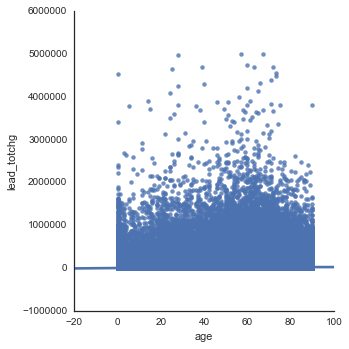

In [25]:
import seaborn as sns

sns.set_style("white")
sns.lmplot("age", "lead_totchg", data=nrd_new, order=2)

In [26]:
## drop outliers 1% highest values
nrd_new = nrd_new[nrd_new['lead_totchg'] < 330913]

In [27]:
## in order to solve the negative value prediction in linear model, we use log(charge) as a variable 
nrd_new['lead_totchg'].describe()

count    1.181097e+07
mean     1.300489e+04
std      3.212376e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.169100e+04
max      3.309090e+05
Name: lead_totchg, dtype: float64

In [28]:
nrd_new['totchg'].describe()

C:\Users\binh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    1.180935e+07
mean     4.150811e+04
std      7.191981e+04
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      5.000000e+06
Name: totchg, dtype: float64

C:\Users\binh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


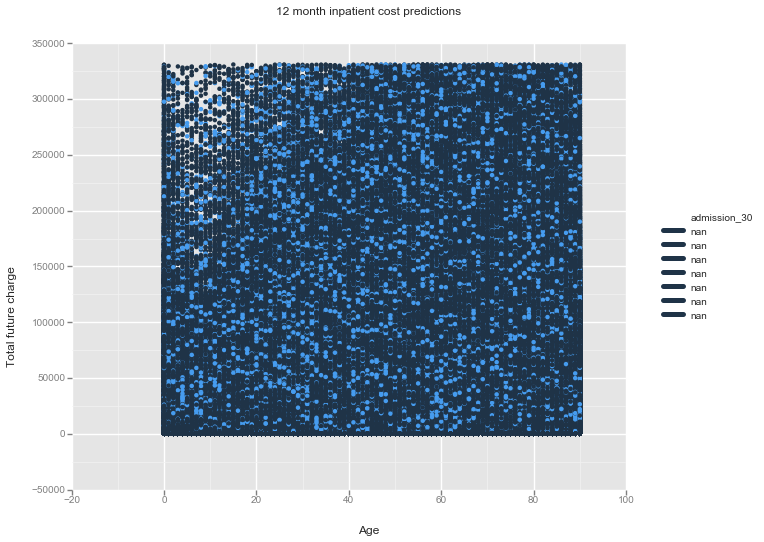

<ggplot: (-9223371887587040231)>

In [ ]:
from ggplot import *
ggplot(nrd_new, aes(x='age', y='lead_totchg', color='admission_30')) +\
    geom_point() +\
    scale_color_brewer(type='diverging', palette=4) +\
    xlab("Age") + ylab("Total future charge") + ggtitle("12 month inpatient cost predictions")

In [ ]:
from ggplot import *
p = ggplot(aes(x='los', y='totchg'), data=nrd_new) 
p + geom_point() + \
    stat_smooth(colour="darkblue") + \
    facet_wrap("female")
p + geom_histogram() 

### correlation plots

In [ ]:
import seaborn as sns

kw = {'axes.edgecolor': '0', 'text.color': '0', 'ytick.color': '0', 'xtick.color': '0',
      'ytick.major.size': 5, 'xtick.major.size': 5, 'axes.labelcolor': '0'}

sns.set_style("whitegrid", kw)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="paper", font="monospace")

# Load the datset of correlations between cortical brain networks
corrmat = nrd_new.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)


## Predictions
Since the lead_totchg is highly skewed with many zero values, we'll do two part modelling which 
- Part 1: Predict whether the lead_totchg will be 0 vs not 0
- Part 2: Take 40% of the people with highest probability and predict the continuous lead_totchg with this number

#### part 1

In [26]:
nrd_new['lead_chg_dummy'] = nrd_new['lead_totchg'].apply(lambda x : +1 if x>0  else 0) 
nrd_new['lead_chg_dummy'].describe()

count    1.184718e+07
mean     3.030709e-01
std      4.595856e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: lead_chg_dummy, dtype: float64

In [27]:
# logistic regression 
target = 'lead_chg_dummy'

features = ['age_50', 'age_64', 'age_74','female', 
            'los_2w', 'los_4w', 'los_6w', 
            'middle','rich', 
            'medicare','medicaid', 'private', 
            'ndx_3','ndx_7','orproc', 'ad_emergency', 'elective', 
            'cm_aids', 'cm_alcohol','cm_anemdef','cm_arth','cm_bldloss','cm_chf','cm_chrnlung','cm_coag', 
            'cm_depress','cm_dm','cm_dmcx','cm_drug','cm_htn_c' , 'cm_hypothy','cm_liver','cm_lymph', 
            'cm_lytes','cm_mets','cm_neuro','cm_obese','cm_para','cm_perivasc','cm_psych','cm_pulmcirc', 
            'cm_renlfail','cm_tumor','cm_ulcer','cm_valve','cm_wghtloss',
           ]

In [28]:
X= nrd_new[features]
Y = nrd_new[target]

# function to split the data
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.1, random_state=42)

In [29]:
# imputation
def imp (XTrain, YTrain, XTest, YTest):
    imp = Imputer(missing_values='NaN', strategy="mean")
    XTrain_Imp = imp.fit_transform(XTrain)
    YTrain_Imp = imp.fit_transform(YTrain.reshape(-1, 1)).ravel().astype(int)   
    XTest_Imp = imp.fit_transform(XTest)
    YTest_Imp = imp.fit_transform(YTest.reshape(-1, 1)).ravel().astype(int)    
    return XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp

XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp = imp(XTrain, YTrain, XTest, YTest) 

### Logistic model

In [30]:
lead_chg_logistic = LogisticRegression()
lead_chg_logistic.fit(XTrain_Imp, YTrain_Imp)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
# k fold validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

seed = 7
kfold = KFold(20, n_folds= 10)
model = LogisticRegression()
scores =  cross_validation.cross_val_score(model, XTrain_Imp , YTrain_Imp, cv=5, scoring='roc_auc')
cross_validation
print("Accuracy: %0.5f (+/- %0.5f)" %(scores.mean(), scores.std() * 2))

lead_score = lead_chg_logistic.score(XTest_Imp, YTest_Imp)
print ('Outpatient model accuracy score, Test data %s' %lead_score)

lead_score_train = lead_chg_logistic.score(XTrain_Imp, YTrain_Imp)
print ('Outpatient model accuracy score, Train data %s' %lead_score_train)


Accuracy: 0.74199 (+/- 0.00073)
Outpatient model accuracy score, Test data 0.722902834261
Outpatient model accuracy score, Train data 0.723822670957


In [32]:
Y_pred = lead_chg_logistic.predict_proba(XTest_Imp)[:,1]
Y_pred_train = lead_chg_logistic.predict(XTrain_Imp)

In [33]:
def model_accuracy (model, x_train, y_train, x_test, y_test, y_predict):
    train_score = model.score(x_train, y_train)
    print('Train data accuracy score: %s' %train_score)
    test_score = model.score(x_test, y_test)
    print('Test data accuracy score: %s' %test_score) 
    roc = metrics.roc_auc_score(y_test, y_predict)
    print('AUC - Area under the ROC curve: %.4f' %roc)
    return train_score, test_score, roc
  
model_accuracy (lead_chg_logistic, XTrain_Imp, YTrain_Imp, XTest_Imp, YTest_Imp, Y_pred)

Train data accuracy score: 0.723822670957
Test data accuracy score: 0.722902834261
AUC - Area under the ROC curve: 0.7416


(0.72382267095748343, 0.72290283426098023, 0.74164394021707725)

In [34]:
nrd_new.shape

(11847179, 62)

In [35]:
nrd_new['lead_chg_dummy'].describe()

count    1.184718e+07
mean     3.030709e-01
std      4.595856e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: lead_chg_dummy, dtype: float64

### Implementation: 
- Implement coefficient system in Precient to calculate probability of having an inpatient visit within a year
- With the top 40% probability we'll implement the second part model (Excel for now)
- Realistically we'll calculate the excel file as the mean of all possible combination with the real cost...

In [36]:
# print  the coefficient
def print_coef (model, XTest):
    logit_export = pd.DataFrame()
    logit_export['feature'] = XTest.columns.values
    logit_export['coef'] = model.coef_.flatten()
    print(logit_export)
    print('Intercept %s' %model.intercept_)
    return 
    
print_coef(lead_chg_logistic, XTest)

         feature      coef
0         age_50  0.180240
1         age_64  0.466773
2         age_74  0.082810
3         female -0.182461
4         los_2w -0.273849
5         los_4w  0.017185
6         los_6w -0.077838
7         middle -0.102458
8           rich -0.184213
9       medicare  0.594250
10      medicaid  0.381609
11       private -0.117391
12         ndx_3 -0.821890
13         ndx_7 -0.266103
14        orproc -0.529445
15  ad_emergency  0.330579
16      elective  0.061389
17       cm_aids  0.615046
18    cm_alcohol  0.111647
19    cm_anemdef  0.297578
20       cm_arth  0.234419
21    cm_bldloss -0.414515
22        cm_chf  0.415154
23   cm_chrnlung  0.278254
24       cm_coag  0.052035
25    cm_depress  0.201494
26         cm_dm  0.240982
27       cm_dmcx  0.293828
28       cm_drug  0.385266
29      cm_htn_c  0.055137
30    cm_hypothy  0.032188
31      cm_liver  0.316416
32      cm_lymph  0.646666
33      cm_lytes  0.076607
34       cm_mets  0.746438
35      cm_neuro  0.203331
3

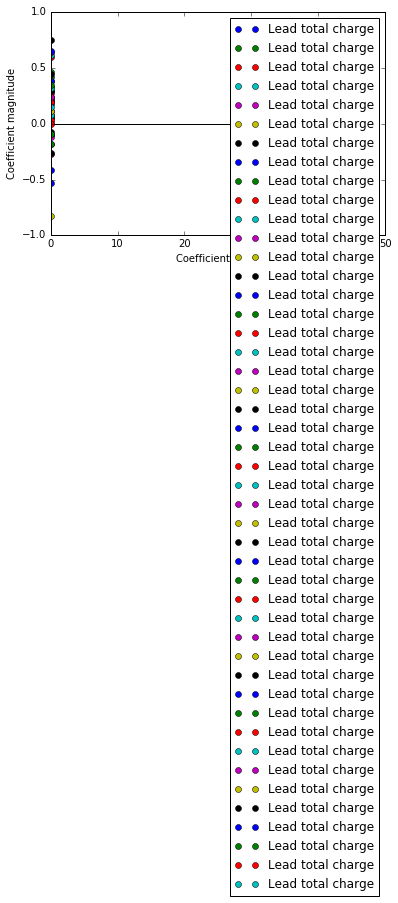

In [112]:
## plot coefficient index == not working
plt.plot(lead_chg_logistic.coef_, 'o', label = "Lead total charge")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.hlines( 0 , 0,len(lead_chg_logistic.coef_.flatten()))
plt.ylim(-1,1)
plt.legend()

###### Fomular to calculate the raw numbers

In [37]:
incost_coef = lead_chg_logistic.coef_.flatten()
print(incost_coef)

incost_intercept = lead_chg_logistic.intercept_
print(incost_intercept)

[ 0.18023975  0.4667729   0.08280992 -0.18246101 -0.27384887  0.01718474
 -0.07783799 -0.10245809 -0.18421329  0.59424992  0.38160898 -0.11739091
 -0.82188979 -0.26610344 -0.52944493  0.33057876  0.0613887   0.6150461
  0.11164745  0.29757788  0.23441948 -0.41451504  0.41515375  0.2782542
  0.05203513  0.20149442  0.24098229  0.29382839  0.38526562  0.05513667
  0.03218767  0.31641632  0.64666626  0.07660735  0.7464381   0.20333134
 -0.09547108  0.19536757  0.08157766  0.24324016  0.11571656  0.4452619
  0.65609692  0.34988471  0.00122826  0.15084472]
[-1.11150038]


In [38]:
## create a dataframe
leadchg_df = pd.DataFrame()

#calculate the scores
leadchg_df['score_calculated'] = 1./(1. + np.exp(-(incost_intercept + (incost_coef * XTrain_Imp).sum(axis=1)))) 
leadchg_df['score'] = lead_chg_logistic.predict_proba(XTrain_Imp)[:,1]
leadchg_df['real'] = YTrain_Imp

leadchg_df.head(10)

,score_calculated,score,real
0,0.239942,0.239942,0
1,0.259709,0.259709,0
2,0.373187,0.373187,0
3,0.163020,0.163020,0
4,0.532361,0.532361,1
5,0.123979,0.123979,0
6,0.155632,0.155632,0
7,0.416917,0.416917,1
8,0.492023,0.492023,0
9,0.135046,0.135046,0


In [39]:
leadchg_df['real'].describe()

count    1.066246e+07
mean     3.030143e-01
std      4.595614e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: real, dtype: float64

In [40]:
# AUC
from sklearn.metrics import roc_auc_score
Y_pred = lead_chg_logistic.predict_proba(XTest_Imp)[:,1]
auc_logit= metrics.roc_auc_score(YTest_Imp, Y_pred)
print('Area under the curve: %s' %auc_logit)

Area under the curve: 0.741643940217


In [41]:
## step 2: Take mean - 1/2SD of the bottom values 
# define high/low threshold
def cal_high_low(var):
    mean = np.mean(var, axis=0)
    std = np.std(var, axis=0)
    high = mean + std/2
    low = mean - std/2
    return high, low

high, low = cal_high_low(Y_pred)

In [42]:
print(low)
print(high)

0.213437140156
0.392698432754


In [43]:
## step 3: drop rows with probability < low (by default ) 
nrd_new['Y_pred_all'] = 1./(1. + np.exp(-(incost_intercept + (incost_coef * X).sum(axis=1)))) 
print('Pred all stats: {}'.format(nrd_new['Y_pred_all'].describe()))
nrd_high = nrd_new[nrd_new.Y_pred_all <low]

Pred all stats: count    1.184718e+07
mean     3.030193e-01
std      1.793134e-01
min      2.785603e-02
25%      1.483188e-01
50%      2.691135e-01
75%      4.247623e-01
max      9.786702e-01
Name: Y_pred_all, dtype: float64


In [44]:
print ('number of row of nrd_new: {}'.format(nrd_new.shape[0]))
print ('number of row of nrd_high: {}'.format(nrd_high.shape[0]))

number of row of nrd_new: 11847179
number of row of nrd_high: 4683845


#### Predict future cost of care for the top 60% with the highest probability of having a positive future costs

In [45]:
target = 'lead_totchg'

features = ['age_50', 'age_64', 'age_74','female', 
            'los_2w', 'los_4w', 'los_6w', 
            'middle','rich', 
            'medicare','medicaid', 'private', 
            'ndx_3','ndx_7','orproc', 'ad_emergency', 'elective', 
            'cm_aids', 'cm_alcohol','cm_anemdef','cm_arth','cm_bldloss','cm_chf','cm_chrnlung','cm_coag', 
            'cm_depress','cm_dm','cm_dmcx','cm_drug','cm_htn_c' , 'cm_hypothy','cm_liver','cm_lymph', 
            'cm_lytes','cm_mets','cm_neuro','cm_obese','cm_para','cm_perivasc','cm_psych','cm_pulmcirc', 
            'cm_renlfail','cm_tumor','cm_ulcer','cm_valve','cm_wghtloss'
           ]

In [46]:
X= nrd_high[features]
Y = nrd_high[target]

# function to split the data
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.1, random_state=42)

In [47]:
# imputation
def imp (XTrain, YTrain, XTest, YTest):
    imp = Imputer(missing_values='NaN', strategy="mean")
    XTrain_Imp = imp.fit_transform(XTrain)
    YTrain_Imp = imp.fit_transform(YTrain.reshape(-1, 1)).ravel().astype(int)   
    XTest_Imp = imp.fit_transform(XTest)
    YTest_Imp = imp.fit_transform(YTest.reshape(-1, 1)).ravel().astype(int)    
    return XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp

XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp = imp(XTrain, YTrain, XTest, YTest) 

#### Linear model
- Just for illustration, won't work in reality because linear model sometimes predict negative values


In [48]:
leadchg_linear = LinearRegression()
leadchg_linear.fit(XTrain_Imp, YTrain_Imp)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
## Model accuracy
from sklearn.metrics import mean_squared_error
y_pred = leadchg_linear.predict(XTest_Imp)
y_pred_train = leadchg_linear.predict(XTrain_Imp)

def model_accuracy (model, x_train, y_train, x_test, y_test, y_predict):
    train_score = model.score(x_train, y_train)
    print('Train data accuracy score (R2): %s' %train_score)
    test_score = model.score(x_test, y_test)
    print('Test data accuracy score (R2): %s' %test_score) 
    return train_score, test_score

model_accuracy (leadchg_linear, XTrain_Imp, YTrain_Imp, XTest_Imp, YTest_Imp, y_pred)

from sklearn.metrics import r2_score
print("Linear model RMSE: {}".format(np.sqrt(mean_squared_error(YTest_Imp, y_pred))))
print("Linear model R2: {}".format(r2_score(YTest_Imp, y_pred)))

Train data accuracy score (R2): 0.0197174883983
Test data accuracy score (R2): 0.018330186089
Linear model RMSE: 27679.8895976672
Linear model R2: 0.018330186088959866


In [50]:
#### Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
leadchg_rf = RandomForestRegressor()
leadchg_rf = leadchg_rf.fit(XTrain_Imp, YTrain_Imp)

In [51]:
Y_pred = leadchg_rf.predict(XTest_Imp)

#model accuracy
model_accuracy (leadchg_rf, XTrain_Imp, YTrain_Imp, XTest_Imp, YTest_Imp, Y_pred)

# Build a forest and compute the feature importances
def forest_importances (model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    FeatureRanking = pd.DataFrame(features, columns=['Feature'])
    FeatureRanking['Importance'] = importances
    FeatureRanking = FeatureRanking.loc[indices]
    return FeatureRanking

forest_importances(leadchg_rf, features)

Train data accuracy score (R2): 0.108667273816
Test data accuracy score (R2): -0.0353395683852


,Feature,Importance
8,rich,0.065326
0,age_50,0.059061
7,middle,0.058323
29,cm_htn_c,0.057875
11,private,0.051194
3,female,0.050551
36,cm_obese,0.047772
16,elective,0.040409
30,cm_hypothy,0.040095
13,ndx_7,0.038518


### boosting model 
- randomforestregressor is not working well in this case. Good R2 for training data, but bad R2 for testing data
- gradientboosting is working better in this case

In [52]:
### boosting model 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
gradientboost = GradientBoostingRegressor().fit(XTrain_Imp, YTrain_Imp)

gradientboost_pred = gradientboost.predict(XTest_Imp)
gradientboost_pred_train = gradientboost.predict(XTrain_Imp)

In [53]:
# mean squared errors 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Linear model RMSE: {}".format(np.sqrt(mean_squared_error(YTest_Imp, gradientboost_pred))))
print("Linear model R2 - test data: {}".format(r2_score(YTest_Imp, gradientboost_pred)))
print("Linear model R2 - train data : {}".format(r2_score(YTrain_Imp, gradientboost_pred_train)))

Linear model RMSE: 27646.06775941023
Linear model R2 - test data: 0.020727709604713818
Linear model R2 - train data : 0.023266811017071953


### Neural networks -- 

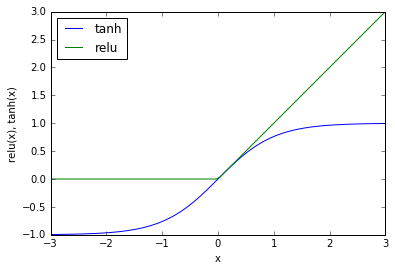

In [54]:
# the hyperbolic tangent activation function and the rectified linear activation function
line = np.linspace(-3,3,100)
plt.plot(line, np.tanh(line), label = "tanh")
plt.plot(line, np.maximum(line,0), label = "relu")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("relu(x), tanh(x)")

## readmission model
- the ROC AUC statistics is not very high. We're wondering whether it is because of our feature selection or because of the tricky nature of the prediction*
- We'll do the same prediction with the current total costs

In [55]:
target = 'new_30_admission'

features = ['age_50', 'age_64', 'age_74','female', 
            'los_2w', 'los_4w', 'los_6w', 
            'middle','rich', 
            'medicare','medicaid', 'private', 
            'ndx_3','ndx_7','orproc', 'ad_emergency', 'elective', 
            'cm_aids', 'cm_alcohol','cm_anemdef','cm_arth','cm_bldloss','cm_chf','cm_chrnlung','cm_coag', 
            'cm_depress','cm_dm','cm_dmcx','cm_drug','cm_htn_c' , 'cm_hypothy','cm_liver','cm_lymph', 
            'cm_lytes','cm_mets','cm_neuro','cm_obese','cm_para','cm_perivasc','cm_psych','cm_pulmcirc', 
            'cm_renlfail','cm_tumor','cm_ulcer','cm_valve','cm_wghtloss'
           ]

In [56]:
nrd_new['new_30_admission'].describe()
X = nrd_new[features]
Y = nrd_new[target]

C:\Users\binh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [57]:
# function to split the data
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.1, random_state=42)
XTrain_Imp , YTrain_Imp, XTest_Imp, YTest_Imp = imp(XTrain, YTrain, XTest, YTest) 

## run logistic regression
readmission_logistic = LogisticRegression()
readmission_logistic.fit(XTrain_Imp, YTrain_Imp)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
Y_pred = readmission_logistic.predict_proba(XTest_Imp)[:,1]
readmission_auc = metrics.roc_auc_score(YTest_Imp, Y_pred)
print('Area under the AUC curve: %0.4f' %readmission_auc)

Area under the AUC curve: 0.7132


### Neural networks

In [59]:
## tuning neural networks
from sklearn.neural_network import MLPClassifier

mpl= MLPClassifier()
mpl.fit(XTrain_Imp, YTrain_Imp)
'''Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more)
in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.'''

'Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more)\nin terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.'

In [97]:
y_nn_pred = mpl.predict_proba(XTest_Imp)[:,1]
nn_roc =  metrics.roc_auc_score(YTest_Imp, y_nn_pred)
print('Area under the AUC curve neural network: %0.4f' %nn_roc)

Area under the AUC curve neural network: 0.7277


In [99]:
### more customize neural networks 
## change the hidden layer sizes
mpl2= MLPClassifier(hidden_layer_sizes=[10,10])
mpl2.fit(XTrain_Imp, YTrain_Imp)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[10, 10], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [100]:
y_nn_pred2 = mpl2.predict_proba(XTest_Imp)[:,1]
nn_roc2 =  metrics.roc_auc_score(YTest_Imp, y_nn_pred2)
print('Area under the AUC curve neural networks -customized hidden layer sizes: %0.4f' %nn_roc2)

Area under the AUC curve neural networks -customized hidden layer sizes: 0.7264


In [102]:
### last method: boosting classifier 
from sklearn.ensemble import GradientBoostingClassifier
gradientboost = GradientBoostingClassifier (n_estimators=200).fit(XTrain_Imp, YTrain_Imp)

gradientboost_pred = gradientboost.predict_proba(XTest_Imp)[:,1]
# area under the curve
auc_gradientboost  =  metrics.roc_auc_score(YTest_Imp, gradientboost_pred)
print('gradient boost classification AUC: {}'.format(auc_gradientboost))


gradient boost classification AUC: 0.7223968171241316


###  gridsearch

In [77]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-5, 2, 30, endpoint=True, base=10.0, dtype=None)

best_score= 0
for n_estimators in [10, 100, 150, 200, 300]
    for max_depth in [2,3,4]   

Lasso best parameters {'alpha': 1.0000000000000001e-05}
Lasso best scores 0.459712323017
0.459712323017 {'alpha': 1.0000000000000001e-05}
0.459712323017 {'alpha': 1.7433288221999873e-05}
0.459712323016 {'alpha': 3.0391953823131949e-05}
0.459712323014 {'alpha': 5.2983169062837125e-05}
0.459712323011 {'alpha': 9.2367085718738658e-05}
0.459712323007 {'alpha': 0.00016102620275609391}
0.459712322998 {'alpha': 0.00028072162039411759}
0.459712322982 {'alpha': 0.00048939009184774938}
0.459712322959 {'alpha': 0.00085316785241728145}
0.459712322914 {'alpha': 0.0014873521072935117}
0.459712322811 {'alpha': 0.0025929437974046669}
0.459712322704 {'alpha': 0.0045203536563602452}
0.459712322467 {'alpha': 0.0078804628156699131}
0.459712321936 {'alpha': 0.013738237958832637}
0.459712321343 {'alpha': 0.023950266199874861}
0.459712320072 {'alpha': 0.041753189365604043}
0.459712317206 {'alpha': 0.072789538439831533}
0.459712313872 {'alpha': 0.12689610031679235}
0.459712306574 {'alpha': 0.22122162910704501

C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [119]:
## Lasso regression - l1 - variable shrinkages toward zero
from sklearn import linear_model
incost_lasso = linear_model.Lasso(alpha= 0.000489390)  #specify alpha here
incost_lasso.fit(XTrain_Imp, YTrain_Imp)

print_coef(incost_lasso, XTest)

         feature          coef
0         age_50  -2328.969718
1         age_64   4233.088181
2         age_74   5131.423813
3         female  -3527.680821
4            los   5574.849196
5         middle   2436.102830
6           rich   5440.906657
7       medicare  -1508.900666
8       medicaid  -2944.343780
9          ndx_3 -16584.114265
10         ndx_7 -11777.390020
11        orproc  38096.650315
12  ad_emergency   5849.067566
13      elective   2760.103701
Intercept 9850.15987104


### lasso gridsearch graphs

(0.0001, 0.31622776601683794)

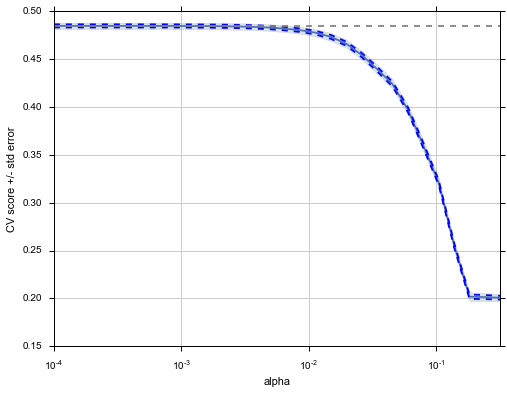

In [85]:
lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, XTrain_Imp, YTrain_Imp, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + 1/2* std_error, 'b--')
plt.semilogx(alphas, scores - 1/2* std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])


## gridsearchcv for ridge regression

In [121]:
from sklearn.linear_model import Ridge
alphas = np.logspace(-5, 2, 30, endpoint=True, base=10.0, dtype=None)
ridge_grid = GridSearchCV(estimator=Ridge(), param_grid = dict(alpha=alphas), cv=10, scoring='r2')
ridge_grid.fit(XTrain_Imp, YTrain_Imp) 

print (' Ridge best parameters %s' %ridge_grid.best_params_)
print (' Ridge best scores %s'  %ridge_grid.best_score_ ) 

for params, mean_score, scores in ridge_grid.grid_scores_:
    print (mean_score, params)    
    
## ridge regression - l2 - variable shrinkages
from sklearn import linear_model
tot_exp_ridge = linear_model.Ridge(alpha=2)
tot_exp_ridge.fit(XTrain_Imp, YTrain_Imp)

print_coef(tot_exp_ridge, XTest)

 Ridge best parameters {'alpha': 57.361525104486816}
 Ridge best scores 0.441510632436
0.441510495035 {'alpha': 1.0000000000000001e-05}
0.441510495035 {'alpha': 1.7433288221999873e-05}
0.441510495035 {'alpha': 3.0391953823131949e-05}
0.441510495035 {'alpha': 5.2983169062837125e-05}
0.441510495035 {'alpha': 9.2367085718738658e-05}
0.441510495036 {'alpha': 0.00016102620275609391}
0.441510495036 {'alpha': 0.00028072162039411759}
0.441510495037 {'alpha': 0.00048939009184774938}
0.441510495039 {'alpha': 0.00085316785241728145}
0.441510495042 {'alpha': 0.0014873521072935117}
0.441510495047 {'alpha': 0.0025929437974046669}
0.441510495056 {'alpha': 0.0045203536563602452}
0.441510495073 {'alpha': 0.0078804628156699131}
0.4415104951 {'alpha': 0.013738237958832637}
0.441510495149 {'alpha': 0.023950266199874861}
0.441510495234 {'alpha': 0.041753189365604043}
0.441510495382 {'alpha': 0.072789538439831533}
0.44151049564 {'alpha': 0.12689610031679235}
0.441510496089 {'alpha': 0.22122162910704501}
0.4

C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### XGboost 

In [78]:
import xgboost as xgb

kf = KFold(YTrain_Imp.shape[0], n_folds=2, shuffle=True, random_state=0)

for train_index, test_index in kf:
    xgb_model = xgb.XGBRegressor().fit(XTrain_Imp,YTrain_Imp)
    predictions = xgb_model.predict(XTest_Imp)
    actuals = YTest_Imp
    print('Mean squared eror: %s' %mean_squared_error(actuals, predictions))

print("Parameter optimization")
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)

clf.fit(XTrain_Imp,YTrain_Imp)
print('Best score: %s' %clf.best_score_)
print('Best parameters: %s' %clf.best_params_)

Mean squared eror: 2480574197.11
Mean squared eror: 2480574197.11
Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.6min finished


Best score: 0.547207756057
Best parameters: {'max_depth': 4, 'n_estimators': 50}


## gradient boosting method

In [87]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
gradientboost = GradientBoostingRegressor().fit(XTrain_Imp, YTrain_Imp)

gradientboost_pred = gradientboost.predict(XTest_Imp)
gradientboost_pred_train = gradientboost.predict(XTrain_Imp)

In [89]:
# mean squared errors 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Linear model RMSE: {}".format(np.sqrt(mean_squared_error(YTest_Imp, gradientboost_pred))))
print("Linear model R2 - test data: {}".format(r2_score(YTest_Imp, gradientboost_pred)))

print("Linear model R2 - train data : {}".format(r2_score(YTrain_Imp, gradientboost_pred_train)))

Linear model RMSE: 43107.50297220956
Linear model R2 - test data: 0.005410923757592445
Linear model R2 - train data : 0.015450780548002085


In [90]:
## create a dataframe
incost_gb = pd.DataFrame()

#calculate the scores
incost_gb['score'] =  gradientboost_pred
incost_gb['real_expenditure'] = YTest_Imp

incost_gb.head(n=20)

,score,real_expenditure
0,44486.966440,49275
1,45178.599344,49275
2,48990.567229,49275
3,47121.523182,49275
4,48199.171238,49275
5,47273.322403,49275
6,47397.795714,49275
7,48296.600125,9006
8,45283.130404,49275
9,48462.609367,49275


In [91]:
incost_gb['score'].describe()

count     33328.000000
mean      48194.540644
std        3232.603662
min       38758.030639
25%       46278.309317
50%       47586.349518
75%       49194.417390
max      117575.673871
Name: score, dtype: float64

In [92]:
incost_gb['real_expenditure'].describe()

count    3.332800e+04
mean     4.927501e+04
std      4.322525e+04
min      2.890000e+02
25%      4.927500e+04
50%      4.927500e+04
75%      4.927500e+04
max      3.779738e+06
Name: real_expenditure, dtype: float64

## Random forest

In [99]:
from sklearn.ensemble import RandomForestRegressor
incost_rf = RandomForestRegressor().fit(XTrain_Imp, YTrain_Imp)

In [199]:
rf_pred = incost_rf.predict(XTest_Imp)
rf_pred_train = incost_rf.predict(XTrain_Imp)

In [201]:
# mean squared errors 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Random forest  RMSE: {}".format(np.sqrt(mean_squared_error(YTest_Imp, rf_pred))))
print("Random forest R2 - test data: {}".format(r2_score(YTest_Imp, gradientboost_pred)))
print("Random forest R2 - train data : {}".format(r2_score(YTrain_Imp, rf_pred_train)))

Linear model RMSE: 53134.61233377713
Linear model R2 - test data: 0.5501942917457687
Linear model R2 - train data : 0.7245438139619853


In [208]:
## create a dataframe
incost_rf = pd.DataFrame()

#calculate the scores
incost_rf['score'] =  rf_pred
incost_rf['real_expenditure'] = YTest_Imp

incost_rf.head(n=20)

,score,real_expenditure
0,60614.089913,107936
1,11107.048022,10226
2,14718.630583,12532
3,12998.840964,3351
4,11343.755933,12670
5,375926.171282,196588
6,39249.158474,28259
7,55951.417229,26289
8,34047.626935,37963
9,16437.199605,13731


In [ ]:
incost_rf['score'].describe()

In [ ]:
incost_rf['real_expenditure'].describe()

## XGBOOST

In [98]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.5, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 
             }
xgb_incost = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                            scoring = 'r2', cv = 5, n_jobs = -1) 

xgb_incost.fit(XTrain_Imp, YTrain_Imp)

xgb_incost.grid_scores_
  
print('Best score: %s' %xgb_incost.best_score_)
print('Best parameters: %s' %xgb_incost.best_params_)


Best score: 0.620560735679
Best parameters: {'min_child_weight': 1, 'max_depth': 3}


C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [213]:
xgb_pred = xgb_incost.predict(XTest_Imp)
xgb_pred_train = xgb_incost.predict(XTrain_Imp)

In [216]:
## model accuracy
print("XGBoost RMSE: {}".format(np.sqrt(mean_squared_error(YTest_Imp, xgb_pred))))
print("XGBoost R2 - test data: {}".format(r2_score(YTest_Imp, xgb_pred)))
print("XGBoost R2 - train data: {}".format(r2_score(YTrain_Imp, xgb_pred_train)))

XGBoost RMSE: 50991.23874571831
XGBoost R2 - test data: 0.527888154077086
XGBoost R2 - train data: 0.6040563183842405
